In [1]:
# -------- IMPORTS --------
from simulation.experiment import ForwardExperiment1D
from utility.distributions import spike, ricker, gaussian, raised_cosine, sinc, homogeneous, exponential, polynomial
from utility.plotting import plot_uv, plot_state, plot_medium, plot_heatmap

In [2]:
# Set IBM Account
# from qiskit_ibm_runtime import QiskitRuntimeService
# QiskitRuntimeService.delete_account()
# QiskitRuntimeService.save_account(
#     channel='ibm_quantum',
#     instance='ibm-q/open/main',
#     token='',
#     overwrite=True
#     )
# service = QiskitRuntimeService()
# service.backends()


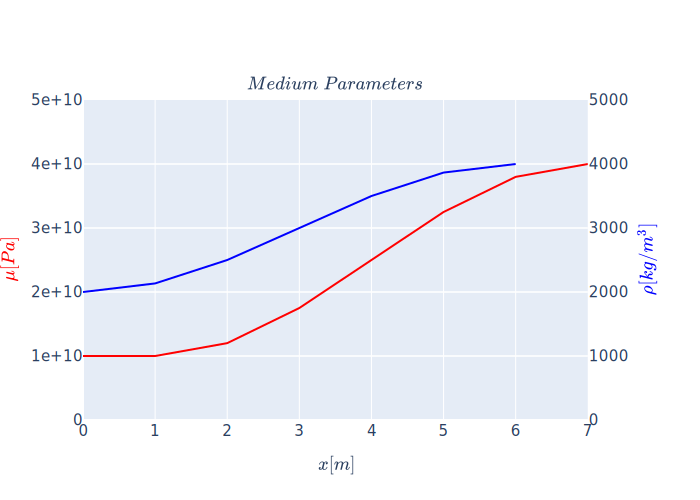

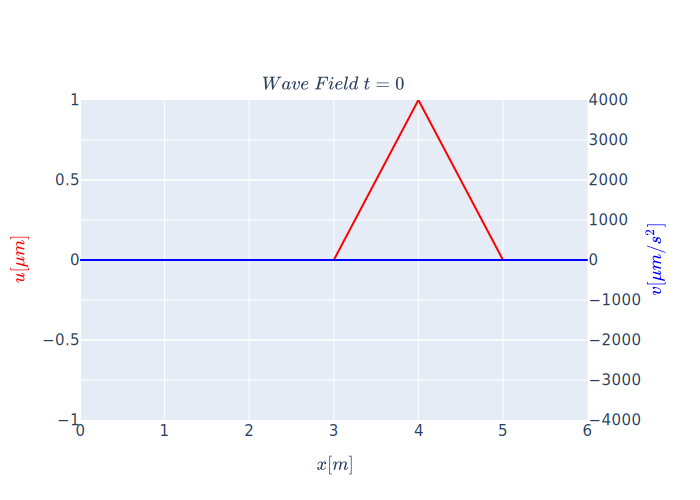

In [3]:
# Define parameters
nx = 7
parameters = {
    'dx': 1,
    'nx': nx, 
    'dt': 0.0002,
    'nt': 19,
    'order': 1,
    'bcs': {'left': 'NBC', 'right': 'DBC'},
    'mu': raised_cosine(3e10, nx+1, nx, 6, 1e10),
    'rho': raised_cosine(2e3, nx, nx-1, 6, 2e3),
    'u': spike(1, nx, nx//2+1),
    'v': homogeneous(0, nx),
    'backend': {
        'shots': 1000,
        'optimization': 3,
        'resilience': 1
        }
    }

# Plot medium and initial state
plot_medium(parameters['mu'], parameters['rho']).show(renderer='svg')
plot_uv(parameters['u'], parameters['v'],0, plot_v=True).show(renderer='svg')


In [4]:
# Run experiment
experiment = ForwardExperiment1D(verbose=2)
experiment.add_solver('ode', **parameters)
#experiment.add_solver('exp', **parameters)
#experiment.add_solver('local', **parameters)
experiment.add_solver('cloud', **parameters)
results = experiment.run()

# Read experiment
#id = ''
#experiment = ForwardExperiment1D(experiment_id=id, verbose=2)
#results = experiment.load()


2023-12-01 21:19:40,711 - INFO - Created experiment with time stamp: 20231201T211940.

2023-12-01 21:19:40,714 - INFO - Adding solver 1: ode
2023-12-01 21:19:40,717 - INFO - Parameters checked for validity.
2023-12-01 21:19:40,718 - INFO - Solving for 19 time steps.
2023-12-01 21:19:40,723 - INFO - Calculating Transformation and Hamiltonian.
2023-12-01 21:19:40,736 - INFO - Calculation completed.
2023-12-01 21:19:40,766 - INFO - Medium initialized.
2023-12-01 21:19:40,766 - INFO - Initial state forward-transformed.
2023-12-01 21:19:40,769 - INFO - Solver 0 added.

2023-12-01 21:19:40,772 - INFO - Adding solver 2: cloud
2023-12-01 21:19:40,774 - INFO - Parameters checked for validity.
2023-12-01 21:19:40,776 - INFO - Solving for 19 time steps.
2023-12-01 21:19:40,778 - INFO - Calculating Transformation and Hamiltonian.
2023-12-01 21:19:40,820 - INFO - Calculation completed.
2023-12-01 21:19:40,824 - INFO - Medium initialized.
2023-12-01 21:19:40,826 - INFO - Initial state transformed.
2

<IBMBackend('ibm_brisbane')>


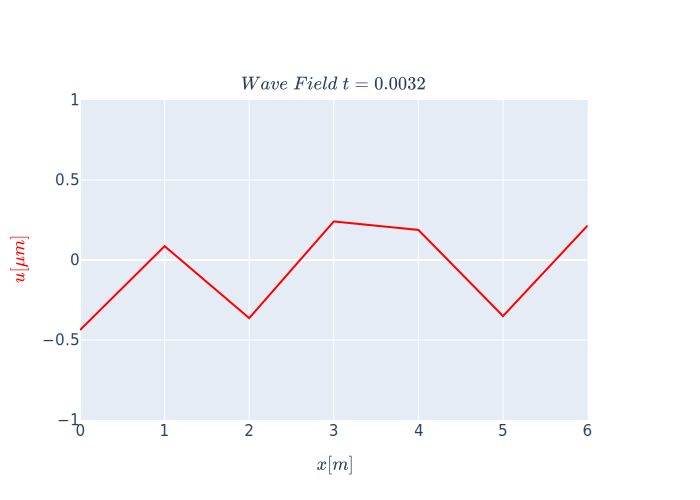

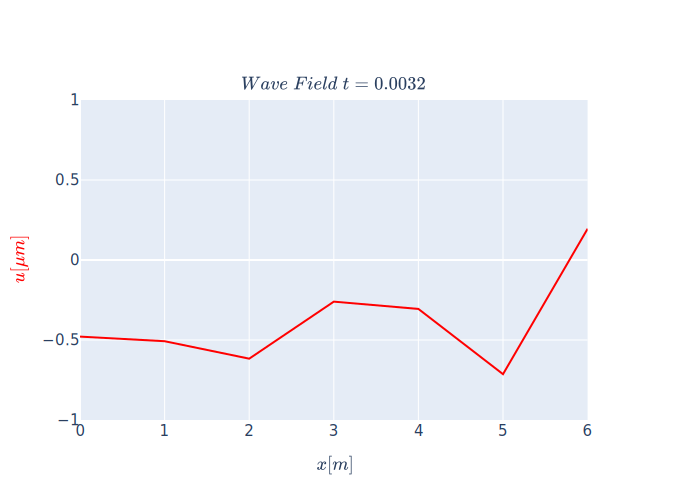

In [ ]:
idx = 16
plot_uv(results[0]['field']['u'][idx],
        results[0]['field']['v'][idx],
        results[0]['times'][idx], plot_v=False).show(renderer='svg')
plot_uv(results[1]['field']['u'][idx],
        results[1]['field']['v'][idx],
        results[1]['times'][idx], plot_v=False).show(renderer='svg')

In [ ]:
# Testing - Accuracy
import numpy as np
import plotly.express as px
l2_errors = np.linalg.norm(results[1]['field']['u'] - results[0]['field']['u'], axis=1) / np.linalg.norm(results[0]['field']['u'], axis=1)
print(np.mean(l2_errors))
px.line(l2_errors)

1.7248889254713
